In [131]:
from data.tanks import two_tank_system
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.optimize import root as sp_root
from scipy.integrate import solve_ivp as sp_solve_ivp
import torch
from stabnode.node import (
    FeluSigmoidMLP,
    GeluSigmoidMLP,
    StabNODE
)
device='cpu'


$$
\mathcal{R}(u)\triangleq g_{\text{NODE}}^K(x_{\text{init}},u) - x_{\text{target}}
$$
$$
u_{n+1} = u_{n} - \eta \nabla \mathcal{R}(u_n)
$$

In [10]:
model_path = "../../results/g_bounds/g_0_1/model_opt_states.pt"

# model_path = "g_0_1/model_opt_states.pt"

f = FeluSigmoidMLP(dims=[2,10,10,2],lower_bound=-1, upper_bound=0)
g = GeluSigmoidMLP(dims=[4,10,10,2],lower_bound=0, upper_bound=1)
model = StabNODE(f,g).to(device)

config = torch.load(model_path, map_location=device, weights_only=False)
f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])

g_eval = g.eval()

In [ ]:
x_target = torch.tensor([0.8,0.2],dtype=torch.float32,requires_grad=False)
x0 = torch.tensor([0.5,0.5],dtype=torch.float32,requires_grad=False)
u0 = torch.tensor([0.5,0.5],dtype=torch.float32,requires_grad=True)
k=10

def R(u,x,k, x_target):
    for _ in range(k):
        x = g_eval(x, u)
    return x - x_target


u = R(u0,x0,k,x_target)

u_norm = torch.sum(u**2)

u_norm.backward()






In [122]:
def u_prime(u,x,x_target,eta,k):
    u = torch.tensor(u,dtype=torch.float32, requires_grad=True)
    x = torch.tensor(x,dtype=torch.float32, requires_grad=False)
    x_target = torch.tensor(x_target,dtype=torch.float32, requires_grad=False)
    resid = torch.sum(R(u,x,k,x_target)**2)
    resid.backward()

    grad = u.grad.numpy()
    return -eta*grad




In [123]:
def two_tank_system_control(t,xu, x_target,eta,k):
    x = xu[:2]
    u = xu[2:]
    dx1dt, dx2dt = two_tank_system(t,x,u)
    dpdt, dvdt = u_prime(u,x,x_target,eta,k)

    return np.hstack([dx1dt,dx2dt,dpdt,dvdt])

In [124]:
xu = np.array([0.5,0.5,0.5,0.5])
x_target = np.array([0.8,0.2])

In [125]:
u_prime(xu[2:],xu[:2],x_target,eta=1e-4,k=10)

array([ 9.8156117e-05, -1.1955423e-04], dtype=float32)

In [126]:
two_tank_system_control(0,xu,x_target,eta=1e-4,k=10)

array([-8.28427125e-03,  2.00000000e-02,  9.81561170e-05, -1.19554228e-04])

In [207]:
xu0 = np.array([0.5,0.5,0.5,0.5])
x_target = np.array([0.2,0.4])
t_max = 300
n_colloc=501
eta=1e-2
k=10

sol = sp_solve_ivp(
    two_tank_system_control,
    t_span=[0,t_max],
    y0 = xu0,
    t_eval=np.linspace(0,t_max,n_colloc),
    args = (x_target,eta,k)
)

In [208]:
t = sol.t

XU = sol.y
X = XU[:2,:]
U = XU[2:,:]

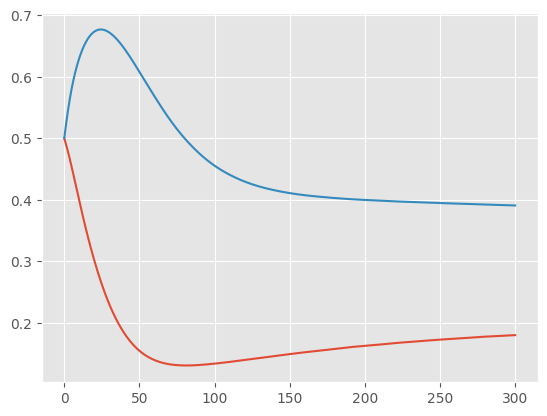

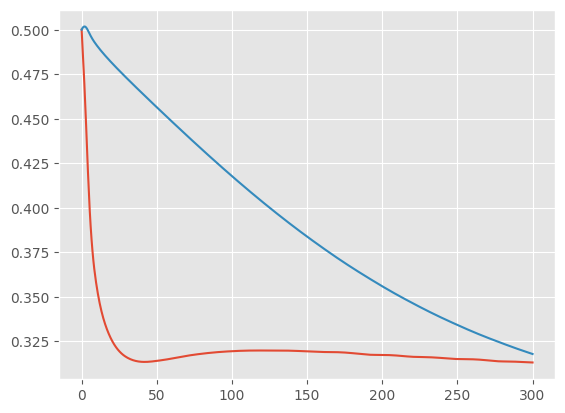

In [209]:
plt.plot(t,X[0,:])
plt.plot(t,X[1,:])
plt.show()
plt.plot(t,U[0,:])
plt.plot(t,U[1,:])

In [188]:
def g_iter(x, u, max_iter):
    for _ in range(max_iter):
        x = g_eval(x, u)
    return x

def control_resid(u, x0, x1, max_iter=10):
    xi = g_iter(x0, u, max_iter)
    return x1 - xi

def control_policy(u0, x0, x1, eta, gd_steps, max_iter=10):
    u = u0.clone().detach().requires_grad_(True)
    resid_hist = []
    grad_norms = []

    for _ in range(gd_steps):
        if u.grad is not None:
            u.grad.zero_()

        resid = torch.sum(control_resid(u, x0, x1, max_iter=max_iter)**2)
        resid_hist.append(resid.item())

        resid.backward()

        with torch.no_grad():
            grad = u.grad
            grad_norms.append(torch.linalg.norm(grad).item())
            u -= eta * grad
            
        u = u.detach().requires_grad_(True)

    return u, resid_hist, grad_norms

In [71]:
control_policy(u0, x0,x_target,eta=1e-2,gd_steps=10)

(tensor([0.5936, 0.4189], requires_grad=True),
 [0.7594255208969116,
  0.734637439250946,
  0.7073194980621338,
  0.6803169846534729,
  0.6551786661148071,
  0.6317561864852905,
  0.6101340651512146,
  0.5933876633644104,
  0.5861436724662781,
  0.5846670269966125],
 [1.5468626022338867,
  1.6471937894821167,
  1.6559007167816162,
  1.6008490324020386,
  1.5422877073287964,
  1.4936423301696777,
  1.3753432035446167,
  0.9923308491706848,
  0.4484955072402954,
  0.2601109743118286])

In [ ]:
def two_tank_cont_control_system(t,x):
    pass